$f(x)=exp(-x_1^2 - 0.5(x_2 - 1)x_2)$

$\hat{f}(x)$ - linear combination of Chebyshev polynomials/their miltiplication

points from uniform distribution from $[-2, 2] \times [-2, 2]$

Рассмотрим задачу аппроксимации функции $f(x)=exp(-x_1^2 - 0.5(x_2 - 1)x_2)$ полиномами Чебышева - полиномами вида: 
$T_0(x) = 1$, $T_1(x)=x$, $T_{n+1}(x) = 2xT_n(x) - T_{n-1}(x)$ на $[-2, 2]^2$.

В классическом подходе: $f(x) \approx \hat{f}(x) = \sum_{i=1}^{M}{\alpha_{i}P_i(x)}$, где $\alpha_i$ могут быть найдены с помощью метода наименьших квадратов, который будет уменьшать норму остатков в выбранных точках множества $[-2, 2]^2$: $\sum{(f(x_i) - \hat{f}(x_i))^2} \to \min$.

Рассмотрим другой подход, использующий информацию о градиентах функции f.
Будем решать следующую задачу: $A\alpha = F$, где $\alpha = (\alpha_1, \alpha_2, \dots, \alpha_M)^T$ - вектор весов, упомянутых выше. Назовем множество выбранных точек из $[-2, 2]^2$ множеством $G=\{(g_{1,1}, g_{1,2}), (g_{2,1}, g_{2,2}), \dots, (g_{k,1}, g_{k,2})\}$. Тогда $F$ - вектор размерности $3k$, состоящий из значений функции $F$ в точках множества $G$ и градиентов в этих же точках сначала по $x_1$, потом по $x_2$:

$$
F = \left(f(g_{1,1}, g_{1,2}), f(g_{2,1}, g_{2,2}), \dots, f(g_{k,1}, g_{k,2}), d_{x1}f(g_{1,1}, g_{1,2}),
d_{x1}f(g_{2,1}, g_{2,2}), \dots, d_{x1}f(g_{k,1}, g_{k,2}), d_{x2}f(g_{1,1}, g_{1,2}),
 \dots, d_{x2}f(g_{k,1}, g_{k,2})
\right).
$$

А матрица $A$ имеет вид:

$$
A=
\begin{bmatrix}
    P_{1}(g_{1,1}, g_{1,2}) & P_{2}(g_{1,1}, g_{1,2}) & \dots  & P_{M}(g_{1,1}, g_{1,2}) \\
    P_{1}(g_{2,1}, g_{2,2}) & P_{2}(g_{2,1}, g_{2,2}) & \dots  & P_{M}(g_{2,1}, g_{2,2}) \\
    \vdots & \vdots & \ddots & \vdots \\
    P_{1}(g_{k,1}, g_{k,2}) & P_{2}(g_{k,1}, g_{k,2}) & \dots  & P_{M}(g_{k,1}, g_{k,2}) \\
    d_{x_1}P_{1}(g_{1,1}, g_{1,2}) & d_{x_1}P_{2}(g_{1,1}, g_{1,2}) & \dots  & d_{x_1}P_{M}(g_{1,1}, g_{1,2}) \\
    d_{x_1}P_{1}(g_{2,1}, g_{2,2}) & d_{x_1}P_{2}(g_{2,1}, g_{2,2}) & \dots  & d_{x_1}P_{M}(g_{2,1}, g_{2,2}) \\
    \vdots & \vdots & \ddots & \vdots \\
    d_{x_1}P_{1}(g_{k,1}, g_{k,2}) & d_{x_1}P_{2}(g_{k,1}, g_{k,2}) & \dots  & d_{x_1}P_{M}(g_{k,1}, g_{k,2}) \\
    d_{x_2}P_{1}(g_{1,1}, g_{1,2}) & d_{x_2}P_{2}(g_{1,1}, g_{1,2}) & \dots  & d_{x_2}P_{M}(g_{1,1}, g_{1,2}) \\
    d_{x_2}P_{1}(g_{2,1}, g_{2,2}) & d_{x_2}P_{2}(g_{2,1}, g_{2,2}) & \dots  & d_{x_2}P_{M}(g_{2,1}, g_{2,2}) \\
    \vdots & \vdots & \ddots & \vdots \\
    d_{x_2}P_{1}(g_{k,1}, g_{k,2}) & d_{x_2}P_{2}(g_{k,1}, g_{k,2}) & \dots  & d_{x_2}P_{M}(g_{k,1}, g_{k,2}) \\
\end{bmatrix}
$$

In [57]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from copy import copy

In [2]:
import types
import functools
def copy_func(f):
    g = types.FunctionType(f.__code__, f.__globals__, name=f.__name__,
                           argdefs=f.__defaults__,
                           closure=f.__closure__)
    g = functools.update_wrapper(g, f)
    g.__kwdefaults__ = f.__kwdefaults__
    return g

def f(x1, x2):
    return np.exp(-np.power(x1, 2) - 0.5 * (x2 - 1) * x2)

def d_f1(x1, x2):
    return np.exp(-np.power(x1, 2) - 0.5 * (x2 - 1) * x2) * (-2*x1)

def d_f2(x1, x2):
    return np.exp(-np.power(x1, 2) - 0.5 * (x2 - 1) * x2) * (-x2 + 0.5)

In [3]:
def Chebyshev_polynom(x, n):
    if n == 0:
        return 1
    if n == 1:
        return x
    return 2 * x * Chebyshev_polynom(x, n - 1) - Chebyshev_polynom(x, n - 2)

def d_Chebyshev_polynom(x, n):
    if n == 0:
        return 0
    if n == 1:
        return 1
    return 2 * x * d_Chebyshev_polynom(x, n - 1) + 2 * Chebyshev_polynom(x, n - 1) - d_Chebyshev_polynom(x, n - 2)

In [4]:
def Fourier_polynom(x, n):
    if n == 0:
        return 1
    if n % 2 == 0:
        return np.sin(n // 2 * x)
    return np.cos((n + 1) // 2 * x)

def d_Fourier_polynom(x, n):
    if n == 0:
        return 0
    if n % 2 == 0:
        return (n // 2) * np.cos(n // 2 * x)
    return -((n + 1) // 2) * np.sin((n + 1) // 2 * x)

In [5]:
def Legendre_polynom(x, n):
    if n == 0:
        return 1
    if n == 1:
        return x
    return (2*n-1)/n*x*Legendre_polynom(x, n-1) - (n-1)/n*Legendre_polynom(x, n-2)

def d_Legendre_polynom(x, n):
    if n == 0:
        return 0
    if n == 1:
        return 1
    return (2*n-1)/n*Legendre_polynom(x, n-1) + (2*n-1)/n*x*d_Legendre_polynom(x, n-1) - (n-1)/n*d_Legendre_polynom(x, n-2)


In [6]:
def Standard_polynom(x, n):
    return x ** n

def d_Standard_polynom(x, n):
    if n == 0:
        return 0
    return n * x ** (n - 1)

In [7]:
def polynom_builder(n, is_first_arg, func):
    t = copy_func(func)
    t.__defaults__ = (n,)
    if is_first_arg:
        return lambda x1, x2: t(x1)
    return lambda x1, x2: t(x2)

def polynom_combination_builder(n1, n2, func1, func2):
    t1 = copy_func(func1)
    t1.__defaults__ = (n1,)
    t2 = copy_func(func2)
    t2.__defaults__ = (n2,)
    return lambda x1, x2: t1(x1) * t2(x2)

In [8]:
def build_polynoms(polynom_type='Chebyshev'):
    if polynom_type == 'Chebyshev':
        polynom = Chebyshev_polynom
    elif polynom_type == 'Fourier':
        polynom = Fourier_polynom
    elif polynom_type == 'Legendre':
        polynom = Legendre_polynom
    elif polynom_type == 'Standard':
        polynom = Standard_polynom
    else:
        raise
    P_polynoms = []
    for deg in range(20):
        P_polynoms.append(polynom_builder(deg, True, polynom))
        t = P_polynoms[0]
        P_polynoms.append(polynom_builder(deg, False, polynom))
        
        for first_monom_deg in range(1, (deg + 1) // 2):
            P_polynoms.append(polynom_combination_builder(first_monom_deg, deg - first_monom_deg, polynom, polynom))
            if first_monom_deg * 2 != deg:
                P_polynoms.append(polynom_combination_builder(deg - first_monom_deg, first_monom_deg, polynom, polynom))
    return P_polynoms

def build_d1_polynoms(polynom_type='Chebyshev'):
    if polynom_type == 'Chebyshev':
        polynom = Chebyshev_polynom
        d_polynom = d_Chebyshev_polynom
    elif polynom_type == 'Fourier':
        polynom = Fourier_polynom
        d_polynom = d_Fourier_polynom
    elif polynom_type == 'Legendre':
        polynom = Legendre_polynom
        d_polynom = d_Legendre_polynom
    elif polynom_type == 'Standard':
        polynom = Standard_polynom
        d_polynom = d_Standard_polynom
    else:
        raise
    P_polynoms = []
    for deg in range(20):
        P_polynoms.append(polynom_builder(deg, True, d_polynom))
        P_polynoms.append(lambda x1, x2: 0)
        
        for first_monom_deg in range(1, (deg + 1) // 2):
            P_polynoms.append(polynom_combination_builder(first_monom_deg, deg - first_monom_deg, d_polynom, polynom))
            if first_monom_deg * 2 != deg:
                P_polynoms.append(polynom_combination_builder(deg - first_monom_deg, first_monom_deg, d_polynom, polynom))
    return P_polynoms

def build_d2_polynoms(polynom_type='Chebyshev'):
    if polynom_type == 'Chebyshev':
        polynom = Chebyshev_polynom
        d_polynom = d_Chebyshev_polynom
    elif polynom_type == 'Fourier':
        polynom = Fourier_polynom
        d_polynom = d_Fourier_polynom
    elif polynom_type == 'Legendre':
        polynom = Legendre_polynom
        d_polynom = d_Legendre_polynom
    elif polynom_type == 'Standard':
        polynom = Standard_polynom
        d_polynom = d_Standard_polynom
    else:
        raise
    P_polynoms = []
    for deg in range(20):
        P_polynoms.append(lambda x1, x2: 0)
        P_polynoms.append(polynom_builder(deg, False, d_polynom))
        
        for first_monom_deg in range(1, (deg + 1) // 2):
            P_polynoms.append(polynom_combination_builder(first_monom_deg, deg - first_monom_deg, polynom, d_polynom))
            if first_monom_deg * 2 != deg:
                P_polynoms.append(polynom_combination_builder(deg - first_monom_deg, first_monom_deg, polynom, d_polynom))
    return P_polynoms

In [9]:
# def build_fourier_polynoms():
#     P_polynoms = []
#     for deg in range(20):
#         P_polymons.append()

In [10]:
Chebyshev_polynoms = build_polynoms(polynom_type='Chebyshev')
d1_Chebyshev_polynoms = build_d1_polynoms(polynom_type='Chebyshev')
d2_Chebyshev_polynoms = build_d2_polynoms(polynom_type='Chebyshev')

Fourier_polynoms = build_polynoms(polynom_type='Fourier')
d1_Fourier_polynoms = build_d1_polynoms(polynom_type='Fourier')
d2_Fourier_polynoms = build_d2_polynoms(polynom_type='Fourier')

Legendre_polynoms = build_polynoms(polynom_type='Legendre')
d1_Legendre_polynoms = build_d1_polynoms(polynom_type='Legendre')
d2_Legendre_polynoms = build_d2_polynoms(polynom_type='Legendre')

Standard_polynoms = build_polynoms(polynom_type='Standard')
d1_Standard_polynoms = build_d1_polynoms(polynom_type='Standard')
d2_Standard_polynoms = build_d2_polynoms(polynom_type='Standard')

In [11]:
assert Standard_polynoms[0](99, 100) == 1
assert Standard_polynoms[1](99, 100) == 1
assert Standard_polynoms[2](99, 100) == 99
assert Standard_polynoms[3](99, 100) == 100
assert Standard_polynoms[4](99, 100) == 99*99
assert d1_Standard_polynoms[4](99, 100) == 2*99

assert Legendre_polynoms[0](99, 100) == 1
assert Legendre_polynoms[1](99, 100) == 1
assert Legendre_polynoms[2](99, 100) == 99
assert Legendre_polynoms[3](99, 100) == 100
assert Legendre_polynoms[4](99, 100) == 1/2*(3*99**2-1)
assert d1_Legendre_polynoms[4](99, 100) == 3*99

assert Chebyshev_polynoms[0](99, 100) == 1
assert Chebyshev_polynoms[1](99, 100) == 1
assert Chebyshev_polynoms[2](99, 100) == 99
assert Chebyshev_polynoms[3](99, 100) == 100

assert Fourier_polynoms[0](1, 2) == 1
assert Fourier_polynoms[1](1, 2) == 1
assert Fourier_polynoms[2](1, 2) == np.cos(1)
assert Fourier_polynoms[3](1, 2) == np.cos(2)
assert Fourier_polynoms[4](1, 2) == np.sin(1)
assert Fourier_polynoms[5](1, 2) == np.sin(2)

assert d1_Fourier_polynoms[0](1, 2) == 0
assert d1_Fourier_polynoms[1](1, 2) == 0
assert d1_Fourier_polynoms[2](1, 2) == -np.sin(1)
assert d1_Fourier_polynoms[3](1, 2) == 0
assert d1_Fourier_polynoms[4](1, 2) == np.cos(1)
assert d1_Fourier_polynoms[5](1, 2) == 0

assert d2_Fourier_polynoms[0](1, 2) == 0
assert d2_Fourier_polynoms[1](1, 2) == 0
assert d2_Fourier_polynoms[2](1, 2) == 0
assert d2_Fourier_polynoms[3](1, 2) == -np.sin(2)
assert d2_Fourier_polynoms[4](1, 2) == 0
assert d2_Fourier_polynoms[5](1, 2) == np.cos(2)

In [12]:
def get_mean_l2_norm(size=50, p_count=5, polynom_type='Chebyshev'):
    if polynom_type == 'Chebyshev':
        P_polynoms = Chebyshev_polynoms
        d1_P_polynoms = d1_Chebyshev_polynoms
        d2_P_polynoms = d2_Chebyshev_polynoms
    elif polynom_type == 'Fourier':
        P_polynoms = Fourier_polynoms
        d1_P_polynoms = d1_Fourier_polynoms
        d2_P_polynoms = d2_Fourier_polynoms
    elif polynom_type == 'Legendre':
        P_polynoms = Legendre_polynoms
        d1_P_polynoms = d1_Legendre_polynoms
        d2_P_polynoms = d2_Legendre_polynoms
    elif polynom_type == 'Standard':
        P_polynoms = Standard_polynoms
        d1_P_polynoms = d1_Standard_polynoms
        d2_P_polynoms = d2_Standard_polynoms
    else:
        raise
    SIZE = size
    P_COUNT = p_count
    
    mean_with_grad = []
    mean_no_grad = []
    for i in range(50):
        points = np.random.uniform(low=(-2, -2), high=(2, 2), size=(SIZE, 2))
        x1s = points[:,0]
        x2s = points[:,1]
        F_with_grad = np.array(
            [f(p[0], p[1]) for p in points] + \
            [d_f1(p[0], p[1]) for p in points] + \
            [d_f2(p[0], p[1]) for p in points])
        F_no_grad = np.array([f(p[0], p[1]) for p in points])
        A_with_grad = np.array(
            [[P_polynoms[i](p[0], p[1]) for i in range(P_COUNT)] for p in points] + \
            [[d1_P_polynoms[i](p[0], p[1]) for i in range(P_COUNT)] for p in points] + \
            [[d2_P_polynoms[i](p[0], p[1]) for i in range(P_COUNT)] for p in points])
        A_no_grad = np.array([[P_polynoms[i](p[0], p[1]) for i in range(P_COUNT)] for p in points])
        r_with_grad = LinearRegression()
        r_no_grad = LinearRegression()
        r_with_grad.fit(A_with_grad, F_with_grad)
        r_no_grad.fit(A_no_grad, F_no_grad)
        def f_model_with_grad(x1, x2):
            return np.sum([r_with_grad.coef_[i] * P_polynoms[i](x1, x2) for i in range(P_COUNT)]) + r_with_grad.intercept_

        def f_model_no_grad(x1, x2):
            return np.sum([r_no_grad.coef_[i] * P_polynoms[i](x1, x2) for i in range(P_COUNT)]) + r_no_grad.intercept_

        test_points = np.random.uniform(low=(-2, -2), high=(2, 2), size=(SIZE, 2))
        test_x1s = points[:,0]
        test_x2s = points[:,1]
        mean_with_grad.append(
            np.linalg.norm(np.array([f(p[0], p[1]) for p in test_points]) - np.array([f_model_with_grad(p[0], p[1]) for p in test_points])))
        mean_no_grad.append(
            np.linalg.norm(np.array([f(p[0], p[1]) for p in test_points]) - np.array([f_model_no_grad(p[0], p[1]) for p in test_points])))
        
#         print(mean_no_grad[-1], end=' ')
#         print(np.linalg.norm(np.array([f(p[0], p[1]) for p in test_points]) - r_no_grad.predict(np.array([[P_polynoms[i](p[0], p[1]) for i in range(P_COUNT)] for p in test_points]))), end=' - ')
#         print(mean_with_grad[-1], end=' ')
#         print(np.linalg.norm(np.array([f(p[0], p[1]) for p in test_points]) - r_with_grad.predict(np.array([[P_polynoms[i](p[0], p[1]) for i in range(P_COUNT)] for p in test_points]))))
    
        
    return np.mean(mean_with_grad), np.mean(mean_no_grad), np.var(mean_with_grad), np.var(mean_no_grad)

In [16]:
get_mean_l2_norm(size=200, p_count=60, polynom_type='Chebyshev')

(0.7039874875233444,
 1.9039943300362077,
 0.004015995858922097,
 1.167312795777038)

In [68]:
get_mean_l2_norm(size=200, p_count=50, polynom_type='Legendre')

(0.7363034583020996,
 1.6724605737050877,
 0.010594828528220896,
 1.0171028830238416)

In [69]:
get_mean_l2_norm(size=200, p_count=50, polynom_type='Fourier')

(0.03934312619192915,
 0.04862208353938961,
 0.00013848819720631864,
 0.0006322075100636735)

In [28]:
get_mean_l2_norm(size=200, p_count=40, polynom_type='Fourier')

(673.9985506347577, 1.2999502145434356, 15540.477170586772, 0.4294300162294833)

In [29]:
get_mean_l2_norm(size=200, p_count=20, polynom_type='Fourier')

(138.56194668852987,
 1.5396919789326051,
 220.3712163378382,
 0.039692706399504785)

In [31]:
def draw_stats_for_methods(methods):
    plt.figure(figsize=(20,10))
    sample_size = 200
    p_counts = np.arange(12, 50, 3)
    for m in methods:
        print(m, end=' ')
        mean_with_grad_res = []
        mean_no_grad_res = []
        var_with_grad_res = []
        var_no_grad_res = []
        for p_count in p_counts:
            print(p_count, end=',')
            mean_with_grad, mean_no_grad, var_with_grad, var_no_grad = get_mean_l2_norm(sample_size, p_count, polynom_type=m)
            mean_with_grad_res.append(mean_with_grad)
            mean_no_grad_res.append(mean_no_grad)
            var_with_grad_res.append(var_with_grad)
            var_no_grad_res.append(var_no_grad)

        plt.plot(p_counts, mean_with_grad_res, label='with grad %s' % m)
        plt.plot(p_counts, mean_no_grad_res, label='no grad %s' % m)
        print()
    plt.title('Mean norm')
    plt.xlabel('max polynom degree')
    plt.ylabel('mean l2-norm')
    plt.legend()
    plt.show()

Chebyshev 12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,


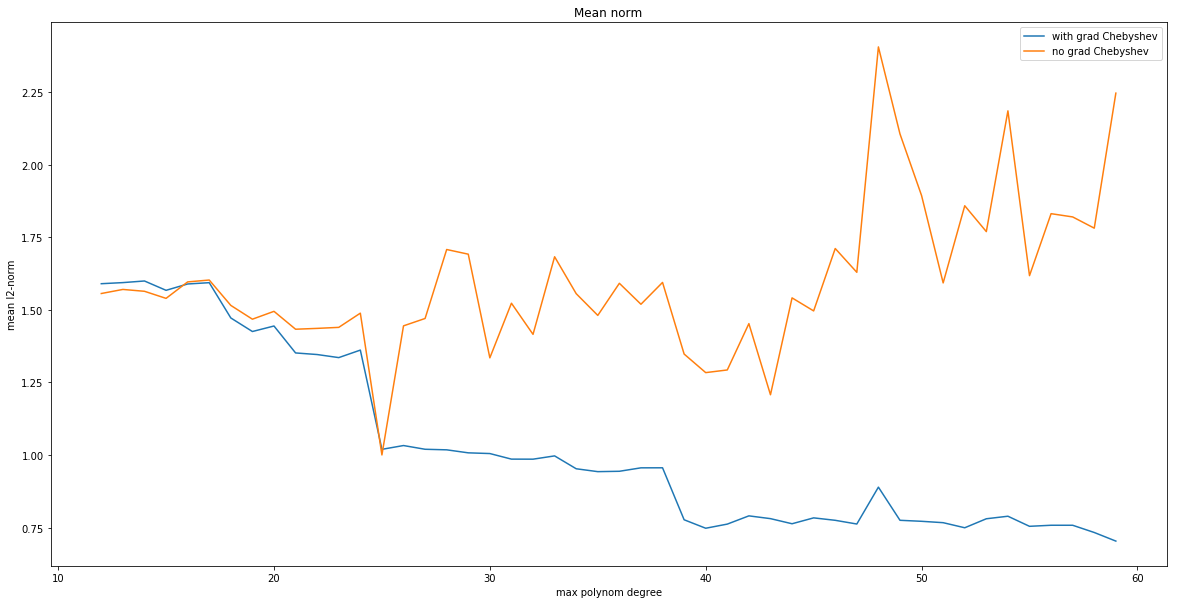

In [30]:
draw_stats_for_methods(['Chebyshev'])

Legendre 12,15,18,21,24,27,30,33,36,39,42,45,48,


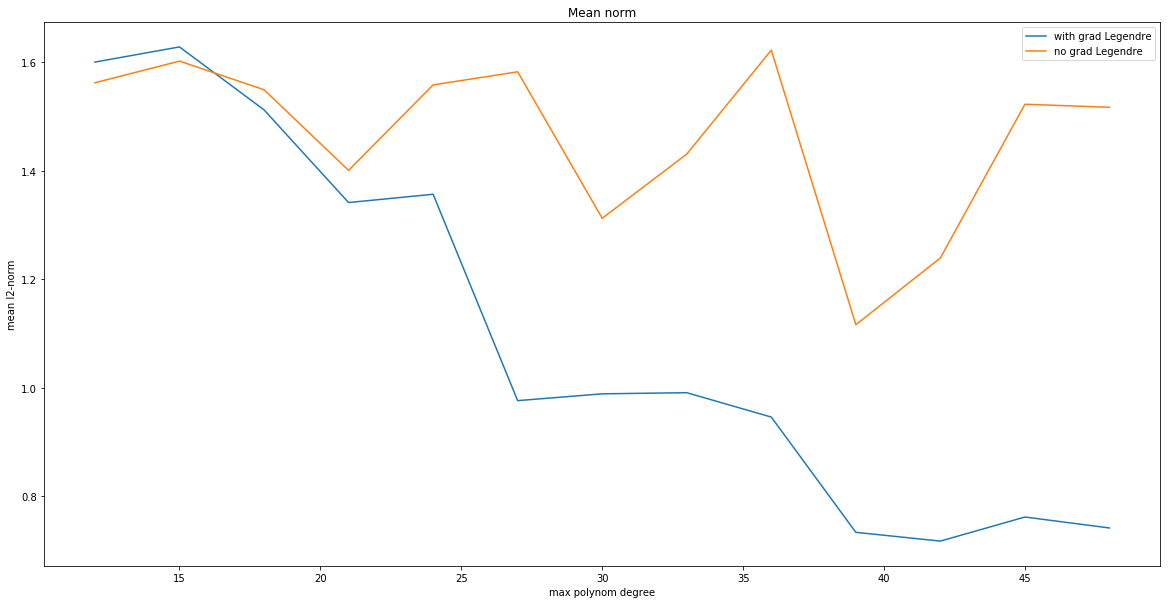

In [32]:
draw_stats_for_methods(['Legendre'])

Fourier 12,15,18,21,24,27,30,33,36,39,42,45,48,


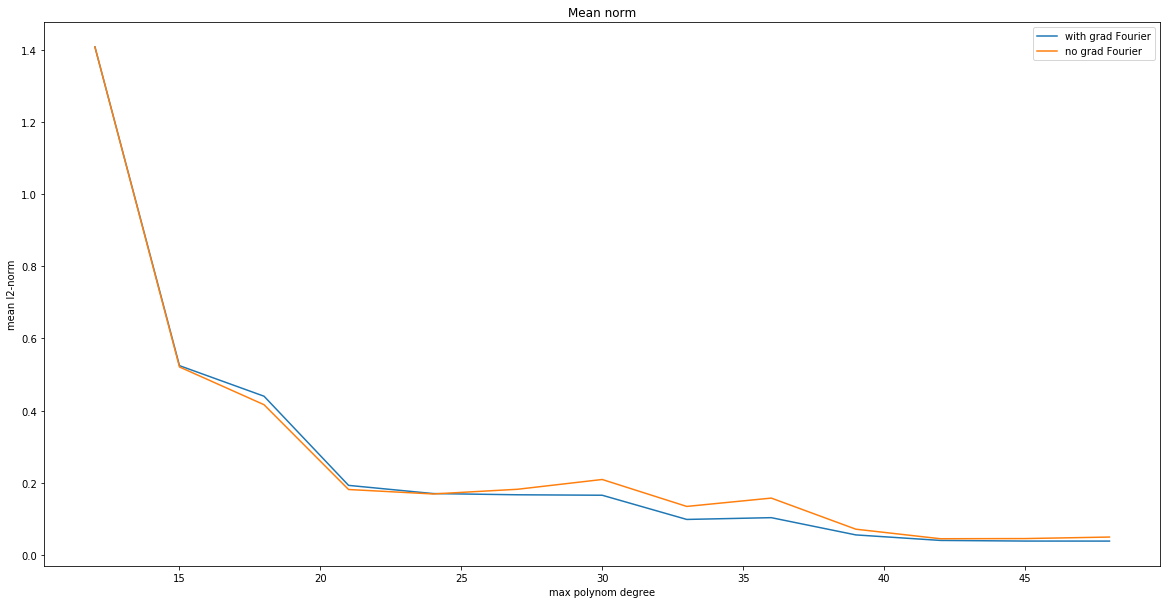

In [33]:
draw_stats_for_methods(['Fourier'])

Standard 12,15,18,21,24,27,30,33,36,39,42,45,48,


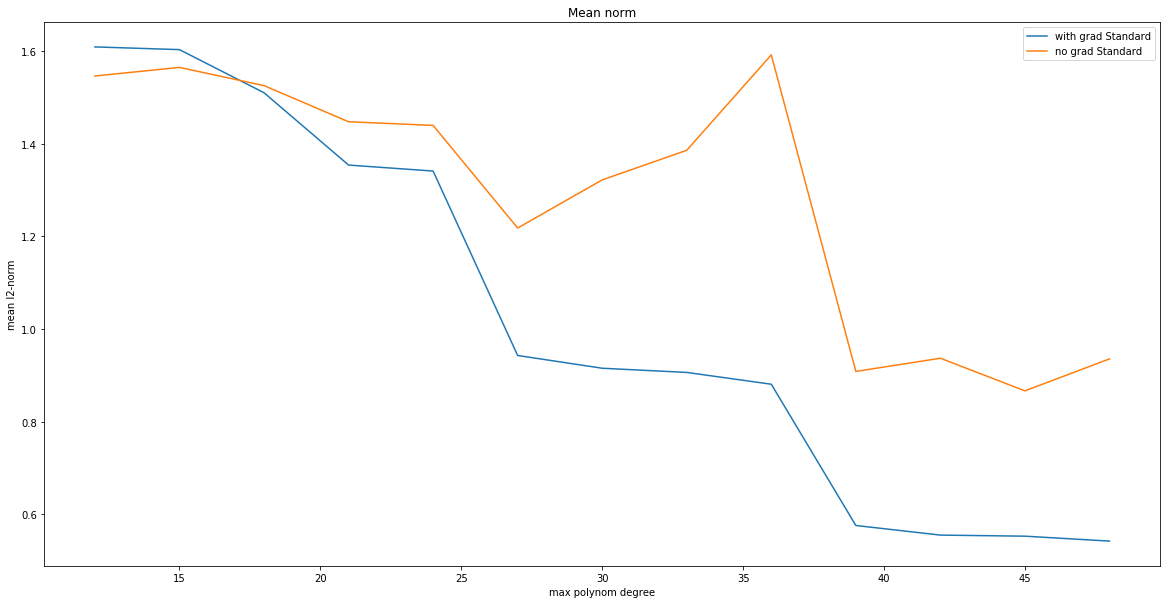

In [35]:
draw_stats_for_methods(['Standard'])

Chebyshev 12,15,18,21,24,27,30,33,36,39,42,45,48,
Standard 12,15,18,21,24,27,30,33,36,39,42,45,48,
Fourier 12,15,18,21,24,27,30,33,36,39,42,45,48,
Legendre 12,15,18,21,24,27,30,33,36,39,42,45,48,


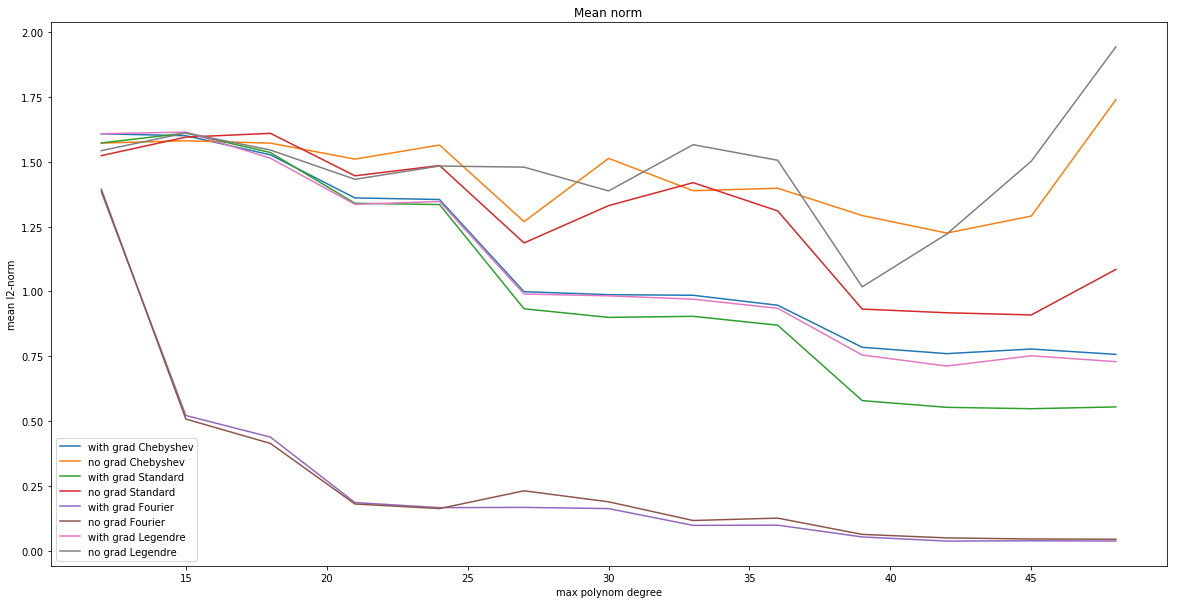

In [36]:
draw_stats_for_methods(['Chebyshev', 'Standard', 'Fourier', 'Legendre'])

In [40]:
def analyse_sensitivity(polynom_type, size=200, p_count=5, bootstrap_cnt=10, verbose=True):
    if polynom_type == 'Chebyshev':
        P_polynoms = Chebyshev_polynoms
        d1_P_polynoms = d1_Chebyshev_polynoms
        d2_P_polynoms = d2_Chebyshev_polynoms
    elif polynom_type == 'Fourier':
        P_polynoms = Fourier_polynoms
        d1_P_polynoms = d1_Fourier_polynoms
        d2_P_polynoms = d2_Fourier_polynoms
    elif polynom_type == 'Legendre':
        P_polynoms = Legendre_polynoms
        d1_P_polynoms = d1_Legendre_polynoms
        d2_P_polynoms = d2_Legendre_polynoms
    elif polynom_type == 'Standard':
        P_polynoms = Standard_polynoms
        d1_P_polynoms = d1_Standard_polynoms
        d2_P_polynoms = d2_Standard_polynoms
    else:
        raise
    SIZE = size
    P_COUNT = p_count
    
    mean_with_grad = []
    mean_no_grad = []
    
    means_with_grad = []
    means_no_grad = []
    
    vars_with_grad = []
    vars_no_grad = []
    for i in range(1):
        main_points = np.random.uniform(low=(-2, -2), high=(2, 2), size=(SIZE, 2))
        # 2d array. Each subarray corresponts to a particular coefficient:
        # coef_stats[i][j] - i_th coefficients of training on j_th bootstrap sample
        # coef_stats[-1][j] - model.intercept_ of training on j_th bootstrap sample
        coef_stats_with_grad = [[] for j in range(P_COUNT + 1)]
        coef_stats_no_grad = [[] for j in range(P_COUNT + 1)]
        for j in range(bootstrap_cnt):
            points = resample(main_points, replace=True, n_samples=size)
            F_with_grad = np.array(
                [f(p[0], p[1]) for p in points] + \
                [d_f1(p[0], p[1]) for p in points] + \
                [d_f2(p[0], p[1]) for p in points])
            F_no_grad = np.array([f(p[0], p[1]) for p in points])
            A_with_grad = np.array(
                [[P_polynoms[i](p[0], p[1]) for i in range(P_COUNT)] for p in points] + \
                [[d1_P_polynoms[i](p[0], p[1]) for i in range(P_COUNT)] for p in points] + \
                [[d2_P_polynoms[i](p[0], p[1]) for i in range(P_COUNT)] for p in points])
            A_no_grad = np.array([[P_polynoms[i](p[0], p[1]) for i in range(P_COUNT)] for p in points])
            r_with_grad = LinearRegression()
            r_no_grad = LinearRegression()
            r_with_grad.fit(A_with_grad, F_with_grad)
            r_no_grad.fit(A_no_grad, F_no_grad)
            for t in range(P_COUNT):
                coef_stats_no_grad[t].append(r_no_grad.coef_[t])
                coef_stats_with_grad[t].append(r_with_grad.coef_[t])
            coef_stats_no_grad[-1].append(r_no_grad.intercept_)
            coef_stats_with_grad[-1].append(r_with_grad.intercept_)
        for t in range(P_COUNT + 1):
            means_with_grad.append(np.mean(coef_stats_with_grad[t]))
            means_no_grad.append(np.mean(coef_stats_no_grad[t]))
            vars_with_grad.append(np.var(coef_stats_with_grad[t]))
            vars_no_grad.append(np.var(coef_stats_no_grad[t]))
        if verbose:
            print(
                ('with grad:\n'
                 '\tmeans: %s\n'
                 '\tvars: %s\n'
                 'no grad:\n'
                 '\tmeans: %s\n'
                 '\tvars: %s\n') % (means_with_grad, vars_with_grad, means_no_grad, vars_no_grad))
        return np.mean(vars_with_grad), np.mean(vars_no_grad)

In [41]:
analyse_sensitivity('Chebyshev', p_count=20)

with grad:
	means: [0.26714865565317497, 0.2671486556531791, 0.015003991798519255, 0.22465646922005317, -0.15929641616687623, -0.06681911336049151, -0.002328731363925714, -0.01968220656227894, -0.004795415049701334, -0.06059098963597378, 0.006982134687659955, 0.0019473341012394701, 0.00012876351503322841, -0.0006930014227313632, 0.0001036345468260541, 0.0004684725686147742, 0.00010625132972924733, 0.001986176644179013, 0.0020153102874593052, -2.9049848458298747e-06, -0.0049825738067491255]
	vars: [6.62891082498303e-05, 6.628910824979909e-05, 0.0001171924707258966, 7.256067807469479e-05, 3.0600158111674874e-05, 2.0944729529219286e-05, 7.098737608918169e-06, 7.42856000601472e-06, 3.4983889270898056e-05, 1.6471751048134426e-05, 1.2688906050040732e-07, 2.7781747719766153e-08, 7.378224911203275e-07, 2.0127748933474256e-07, 3.64178010860687e-08, 1.4025414179483758e-08, 8.131843128084374e-08, 3.112035258096633e-08, 7.355235595522288e-08, 1.5014852897707449e-07, 0.00011867729944684644]
no grad

(2.666746876165055e-05, 3.876483520216734e-05)

In [65]:
def draw_sensitivity_stats_for_methods(methods, left=12, right=50, horizontal_plots_cnt=1, horizontal_plot_ind=1):
    plt.figure(figsize=(20,6 * horizontal_plots_cnt))
    sample_size = 200
    p_counts = np.arange(left, right, 3)
    mean_var_with_grad_res_per_method = []
    mean_var_no_grad_res_per_method = []
    for m in methods:
        print(m, end=' ')
        mean_var_with_grad_res = []
        mean_var_no_grad_res = []
        for p_count in p_counts:
            print(p_count, end=',')
            mean_var_with_grad, mean_var_no_grad = analyse_sensitivity(size=sample_size, p_count=p_count, polynom_type=m, verbose=False, bootstrap_cnt=10)
            mean_var_with_grad_res.append(mean_var_with_grad)
            mean_var_no_grad_res.append(mean_var_no_grad)

        mean_var_with_grad_res_per_method.append(copy(mean_var_with_grad_res))
        mean_var_no_grad_res_per_method.append(copy(mean_var_no_grad_res))
        print()
    plt.subplot(horizontal_plots_cnt, 3, (horizontal_plot_ind - 1) * 3 + 3)
    for i in range(len(methods)):
        m = methods[i]
        plt.plot(p_counts, mean_var_with_grad_res_per_method[i], label='with grad %s' % m)
        plt.plot(p_counts, mean_var_no_grad_res_per_method[i], label='no grad %s' % m)
    plt.legend()
    plt.subplot(horizontal_plots_cnt, 3, (horizontal_plot_ind - 1) * 3 + 1)
    for i in range(len(methods)):
        m = methods[i]
        plt.plot(p_counts, mean_var_with_grad_res_per_method[i], label='with grad %s' % m)
    plt.legend()
    plt.subplot(horizontal_plots_cnt, 3, (horizontal_plot_ind - 1) * 3 + 2)
    for i in range(len(methods)):
        m = methods[i]
        plt.plot(p_counts, mean_var_no_grad_res_per_method[i], label='no grad %s' % m)
    plt.title('Mean var of coefficients')
    plt.xlabel('max polynom degree')
    plt.ylabel('mean var of coefficients')
    plt.legend()

Chebyshev 12,15,18,21,24,27,30,33,36,39,42,45,48,


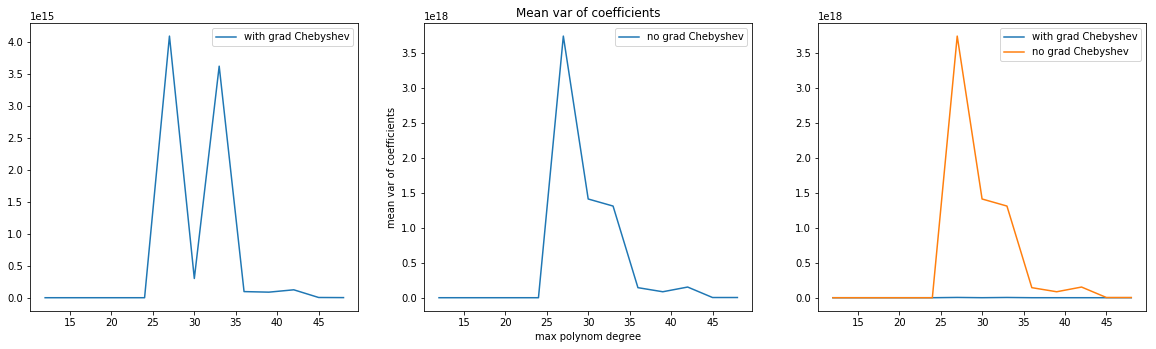

Chebyshev 12,15,18,21,24,


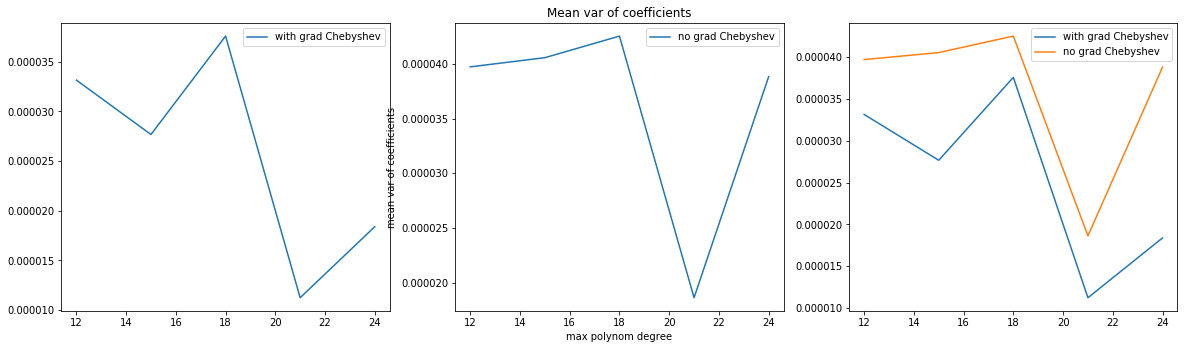

Chebyshev 44,47,50,53,56,59,


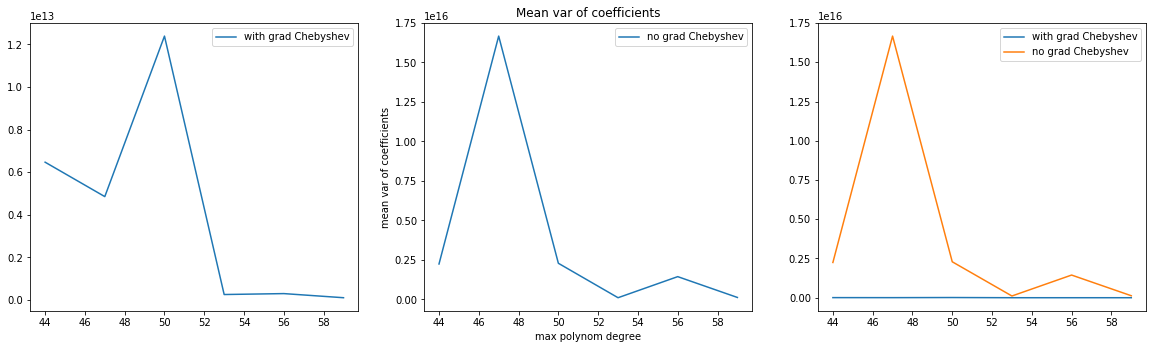

In [67]:
draw_sensitivity_stats_for_methods(['Chebyshev'], horizontal_plots_cnt=3, horizontal_plot_ind=1)
draw_sensitivity_stats_for_methods(['Chebyshev'], horizontal_plots_cnt=3, horizontal_plot_ind=2, left=12, right=25)
draw_sensitivity_stats_for_methods(['Chebyshev'], horizontal_plots_cnt=3, horizontal_plot_ind=3, left=44, right=60)
plt.show()

Legendre 12,15,18,21,24,27,30,33,36,39,42,45,48,


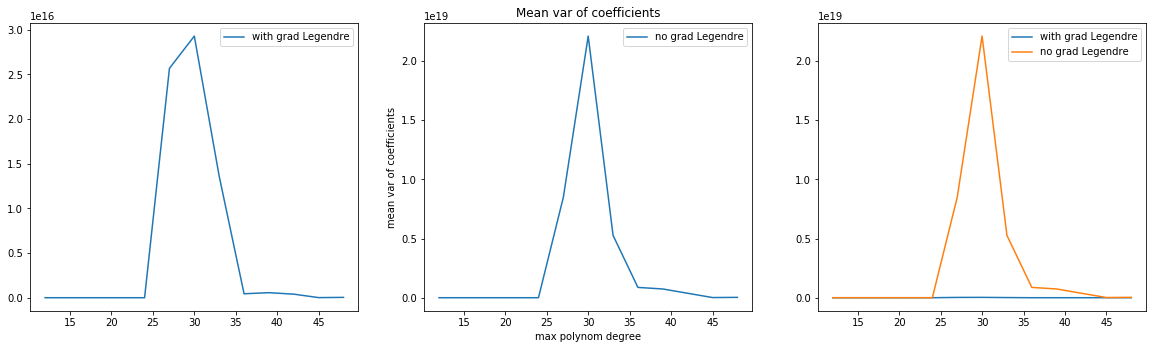

Legendre 12,15,18,21,24,


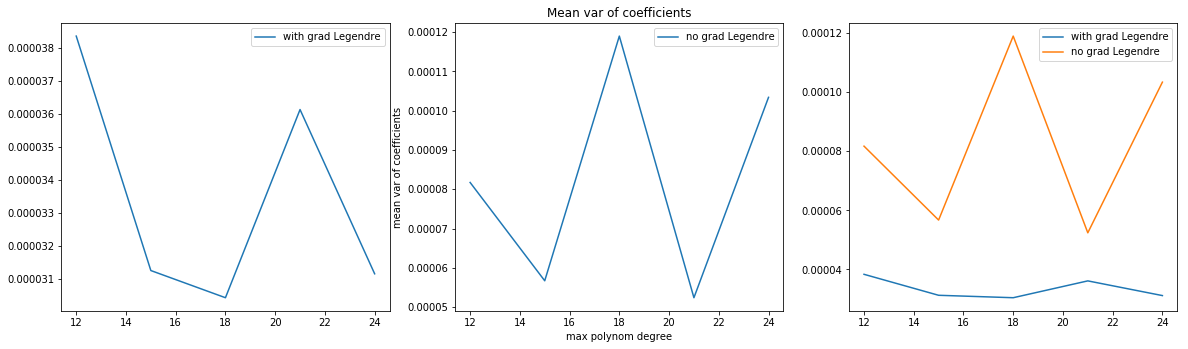

Legendre 44,47,


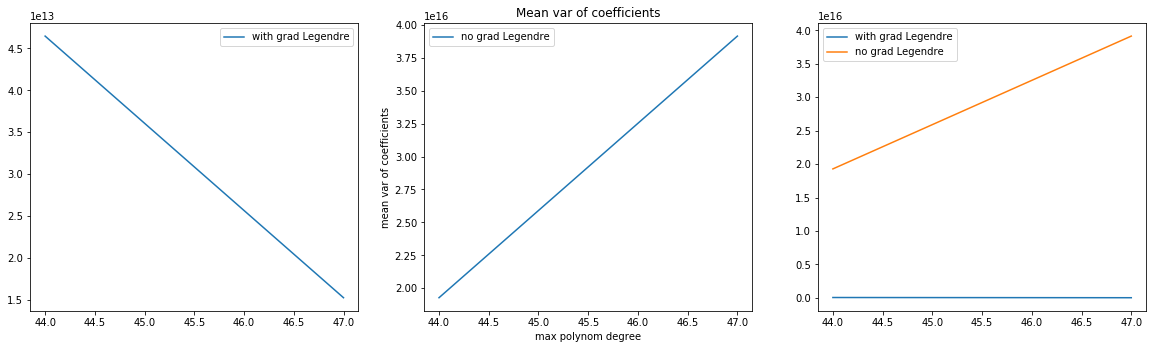

In [69]:
draw_sensitivity_stats_for_methods(['Legendre'], horizontal_plots_cnt=3, horizontal_plot_ind=1)
draw_sensitivity_stats_for_methods(['Legendre'], horizontal_plots_cnt=3, horizontal_plot_ind=2, left=12, right=25)
draw_sensitivity_stats_for_methods(['Legendre'], horizontal_plots_cnt=3, horizontal_plot_ind=3, left=44, right=50)
plt.show()

Fourier 12,15,18,21,24,27,30,33,36,39,42,45,48,


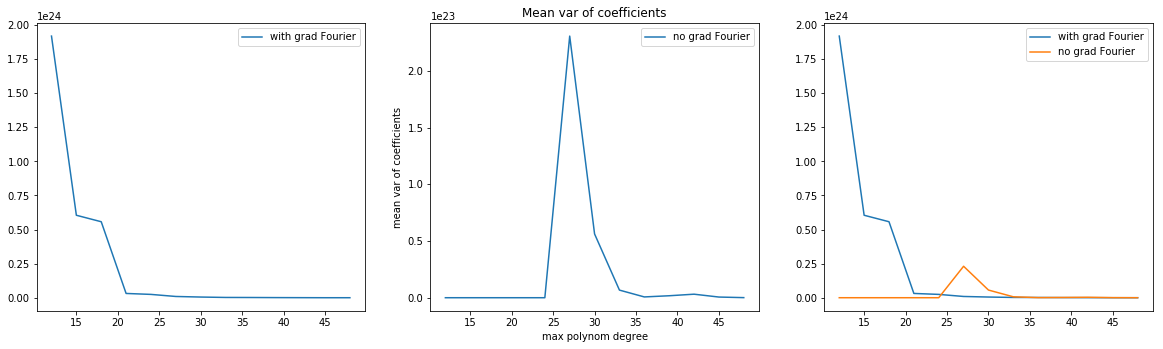

Fourier 12,15,18,21,24,


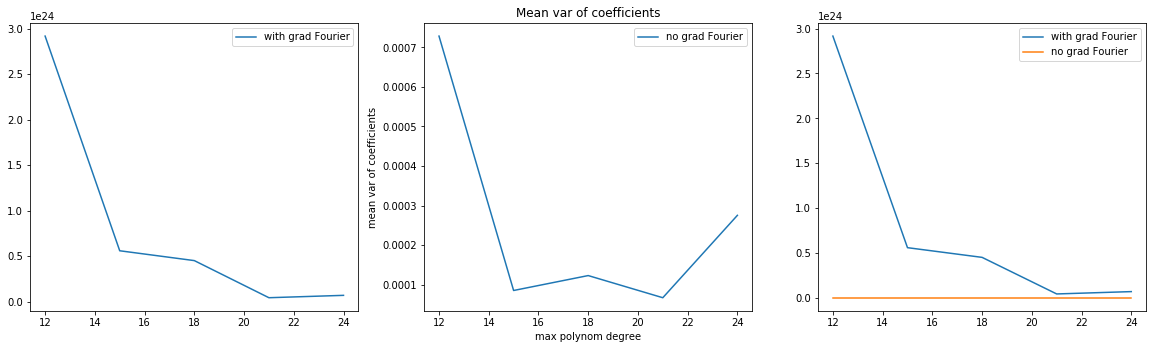

Fourier 44,47,50,53,56,59,


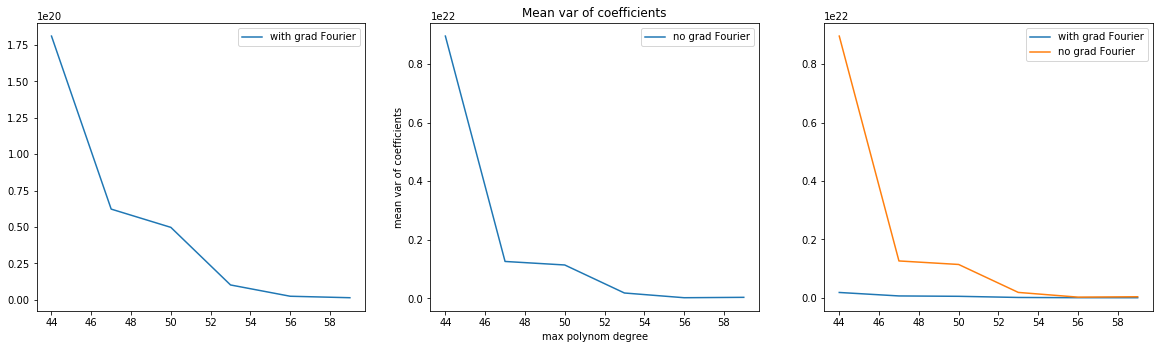

In [71]:
draw_sensitivity_stats_for_methods(['Fourier'], horizontal_plots_cnt=3, horizontal_plot_ind=1)
draw_sensitivity_stats_for_methods(['Fourier'], horizontal_plots_cnt=3, horizontal_plot_ind=2, left=12, right=25)
draw_sensitivity_stats_for_methods(['Fourier'], horizontal_plots_cnt=3, horizontal_plot_ind=3, left=44, right=60)
plt.show()

Standard 12,15,18,21,24,27,30,33,36,39,42,45,48,


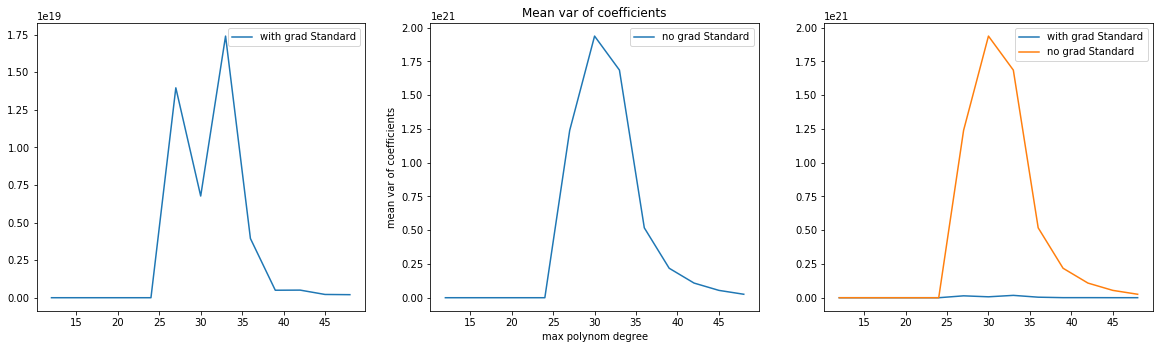

Standard 12,15,18,21,24,


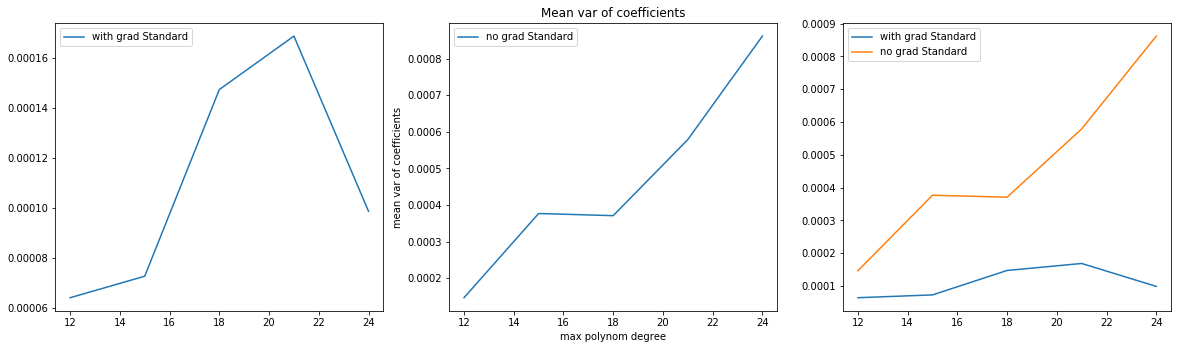

Standard 55,58,61,64,67,70,73,76,79,


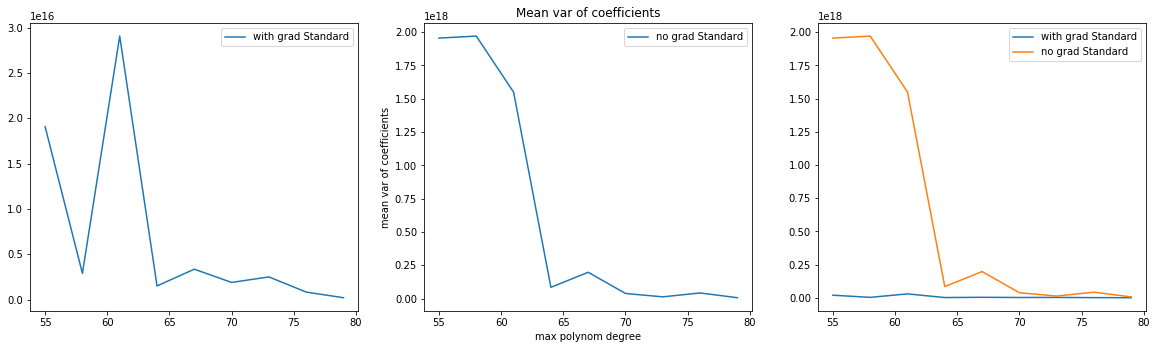

In [74]:
draw_sensitivity_stats_for_methods(['Standard'], horizontal_plots_cnt=3, horizontal_plot_ind=1)
draw_sensitivity_stats_for_methods(['Standard'], horizontal_plots_cnt=3, horizontal_plot_ind=2, left=12, right=25)
draw_sensitivity_stats_for_methods(['Standard'], horizontal_plots_cnt=3, horizontal_plot_ind=3, left=55, right=80)
plt.show()

Standard 12,15,18,21,24,27,30,33,36,39,42,45,48,
Fourier 12,15,18,21,24,27,30,33,36,39,42,45,48,
Legendre 12,15,18,21,24,27,30,33,36,39,42,45,48,
Chebyshev 12,15,18,21,24,27,30,33,36,39,42,45,48,


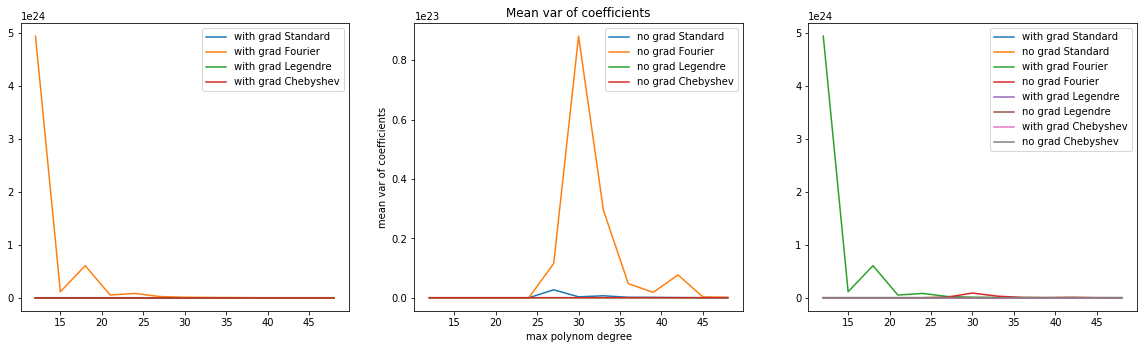

Standard 12,15,18,21,24,
Fourier 12,15,18,21,24,
Legendre 12,15,18,21,24,
Chebyshev 12,15,18,21,24,


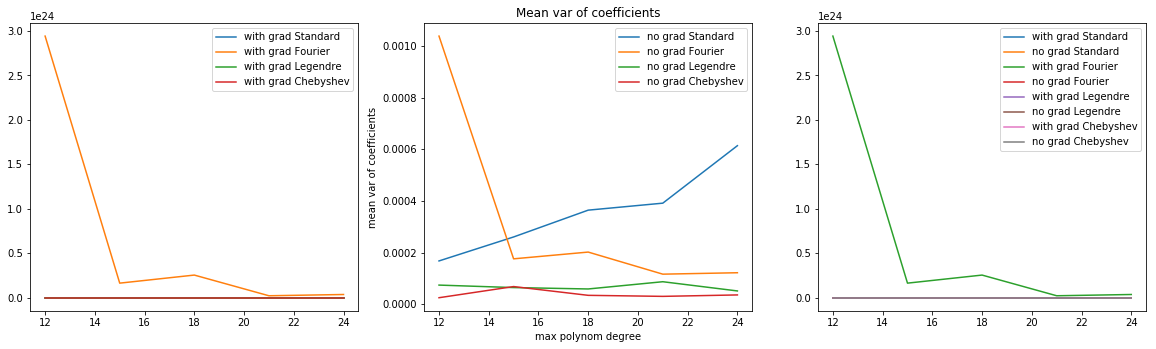

Standard 25,28,31,34,37,40,43,46,49,52,55,58,
Fourier 25,28,31,34,37,40,43,46,49,52,55,58,
Legendre 25,28,31,34,37,40,43,46,49,52,55,58,
Chebyshev 25,28,31,34,37,40,43,46,49,52,55,58,


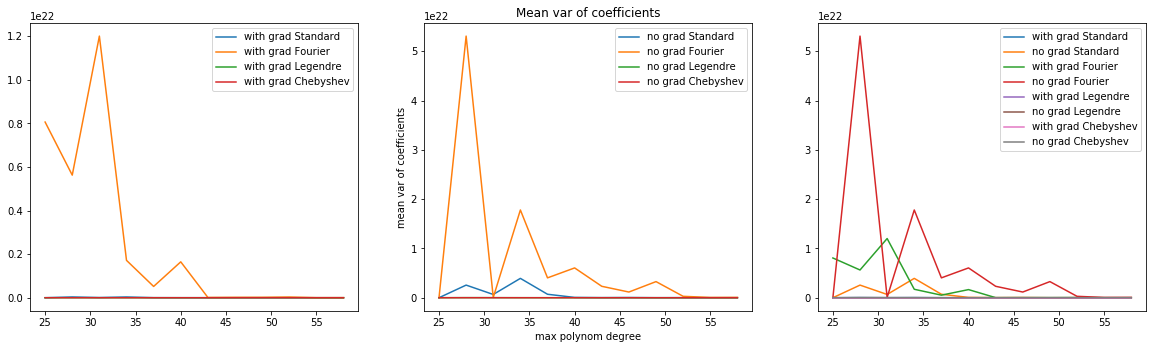

In [75]:
draw_sensitivity_stats_for_methods(['Standard', 'Fourier', 'Legendre', 'Chebyshev'], horizontal_plots_cnt=3, horizontal_plot_ind=1)
draw_sensitivity_stats_for_methods(['Standard', 'Fourier', 'Legendre', 'Chebyshev'], horizontal_plots_cnt=3, horizontal_plot_ind=2, left=12, right=25)
draw_sensitivity_stats_for_methods(['Standard', 'Fourier', 'Legendre', 'Chebyshev'], horizontal_plots_cnt=3, horizontal_plot_ind=3, left=25, right=60)
plt.show()